试一些真实世界的数据集。对于每个数据集，将使用本书中提到的技术，从数据中提取数据的意义。已经介绍的技术可以被应用到所有其他数据集上。

示例数据集可在附带的GitHub仓库（http://github.com/wesm/pydata-book ）中找到。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## 14.1　从Bitly获取1.USA.gov数据
2011年，短网址服务商Bitly（https://bitly.com/ ）与美国政府网站USA.gov（https://www.usa.gov/ ）合作，提供从以.gov或.mil结尾的短网址的用户收集的匿名数据。2011年，可以下载的文本文件提供实时供稿和小时快照。目前此服务已关闭，但保留了一个数据文件作为本书的示例。

在每小时快照的情况下，每个文件中的每一行都包含一种通用形式的web数据，称为JSON，它是JavaScript Object Notation的简写。例如，如果只读取文件的第一行，可能会看到类似这样的内容：

In [2]:
path = 'datasets/bitly_usagov/example.txt'

with open(path) as f:
    print(f.readline())

{ "a": "Mozilla\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\/535.11 (KHTML, like Gecko) Chrome\/17.0.963.78 Safari\/535.11", "c": "US", "nk": 1, "tz": "America\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\/\/www.facebook.com\/l\/7AQEFzjSi\/1.usa.gov\/wfLQtf", "u": "http:\/\/www.ncbi.nlm.nih.gov\/pubmed\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }



Python拥有用于将JSON字符串转换为Python字典对象的内置和第三方库。这里在每一行中使用json模块及其`loads`函数：

In [3]:
import json
path = 'datasets/bitly_usagov/example.txt'
records = [json.loads(line) for line in open(path)]

结果对象records现在是一个Python字典的列表：

In [4]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

### 14.1.1　纯Python时区计数
假设想要找到数据集中最常出现的时区（tz字段）。有很多方法可以实现这一点。首先，我们使用列表再次提取时区列表：

In [5]:
time_zones = [rec['tz'] for rec in records]

KeyError: 'tz'

结果并不是所有的记录都有时区字段。这很容易处理，可以在列表推导式的结尾添加一个检查`if 'tz' in rec`：

In [39]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

只看前10个时区，可以看到其中一些是未知的（空字符串）。也可以过滤掉这些，但现在把它们留下。为了按时区生成计数，展示两种方法：更难的方法（仅使用Python标准库）和更简单的方法（使用pandas）。计数的一种方法是在遍历时区时使用字典来存储计数：

In [40]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

使用更多Python标准库中的高级工具，可以用更简明的方式写出同样的东西：

In [41]:
from collections import defaultdict

def get_counts2(sequence):
    counts = defaultdict(int) # 值将会初始化为0
    for x in sequence:
        counts[x] += 1
    return counts

把这个逻辑放在一个函数中，使它有更好的可重用性。要在时区上使用它，只需传递time_zones列表：

In [42]:
counts = get_counts(time_zones)

counts['America/New_York']

1251

In [43]:
len(time_zones)

3440

如果想要前十的时区和它们的计数，可以做一些字典技巧：

In [44]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort(reverse=True)
    return value_key_pairs[:n]
    #return value_key_pairs[-n:]


top_counts(counts)

[(1251, 'America/New_York'),
 (521, ''),
 (400, 'America/Chicago'),
 (382, 'America/Los_Angeles'),
 (191, 'America/Denver'),
 (74, 'Europe/London'),
 (37, 'Asia/Tokyo'),
 (36, 'Pacific/Honolulu'),
 (35, 'Europe/Madrid'),
 (33, 'America/Sao_Paulo')]

如果搜索Python标准库，可能会发现`collections.Counter`类，它可以使任务更加简单：

In [45]:
from collections import Counter

counts = Counter(time_zones)

counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

In [46]:
a=[1,2,3]
a.sort(reverse=True)
a

[3, 2, 1]

### 14.1.2　使用pandas进行时区计数
根据原始的记录集合生成DataFrame非常简单，只需要把记录的列表传递给`pandas.DataFrame`：

In [47]:
import pandas as pd

frame = pd.DataFrame(records)

frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
_heartbeat_    120 non-null float64
a              3440 non-null object
al             3094 non-null object
c              2919 non-null object
cy             2919 non-null object
g              3440 non-null object
gr             2919 non-null object
h              3440 non-null object
hc             3440 non-null float64
hh             3440 non-null object
kw             93 non-null object
l              3440 non-null object
ll             2919 non-null object
nk             3440 non-null float64
r              3440 non-null object
t              3440 non-null float64
tz             3440 non-null object
u              3440 non-null object
dtypes: float64(4), object(14)
memory usage: 500.7+ KB


In [48]:
frame['tz'].head(10)

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

frame的输出显示的是概要视图，用于展示大型DataFrame对象。对于Series，可以使用`value_counts`方法：

In [49]:
tz_counts = frame['tz'].value_counts()

tz_counts.head(10)

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

可以使用matplotlib对这些数据可视化。可以进行一些清理工作，以便为记录中的未知和缺失的时区数据填入替代值。用`fillna`方法替换缺失值，并为空字符串使用布尔数组索引：

In [50]:
clean_tz = frame['tz'].fillna('Missing')

clean_tz[clean_tz == ''] = 'Unknown'
tz_counts = clean_tz.value_counts()

tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

在这里，可以使用seaborn包（http://seaborn.pydata.org/ ）来绘制一个水平柱状图：

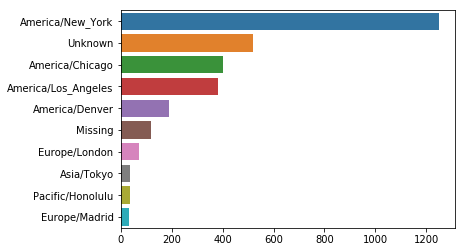

In [51]:
subset = tz_counts[:10]

sns.barplot(y=subset.index, x=subset.values)

a列包含了执行网址缩短的浏览器、设备或应用的信息：

In [52]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [53]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [54]:
frame['a'][50][:50]  # 很长的一行

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/2010'

解析这些“代理”字符串中的所有感兴趣的信息可能看起来像是一项艰巨的任务。一种可能的策略是分离字符串中的第一个标记（粗略地对应于浏览器功能），并对用户行为进行另一个概括：

In [55]:
results = pd.Series([x.split()[0] for x in frame.a.dropna()])

results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [56]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

现在，假设想将时区计数多的时区记录分解为Windows和非Windows用户。作为简化，如果字符串'Windows'在代理字符串中，就认为用户在Windows上。由于一些代理字符串的缺失，将从数据中排除这些代理字符串：

In [57]:
# 这里需要使用原frame的副本
# cframe = frame[frame.a.notnull()]会出现SettingWithCopyWarning的告警
cframe = frame[frame.a.notnull()].copy()

之后想要计算一个代表每一行是否是Windows的值：

In [58]:
cframe['os'] = np.where(cframe.loc[:,'a'].str.contains('Windows'),
                        'Windows', 'Not Windows')

之后，可以根据时区列以及新生成的操作系统列对数据进行分组：

In [59]:
by_tz_os = cframe.groupby(['tz', 'os'])

与`value_counts`函数类似，分组计数可以使用`size`计算。然后可以使用`unstack`对计算结果进行重塑：

In [60]:
agg_counts = by_tz_os.size().unstack().fillna(0)

agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，选出总体计数最高的时区。要实现这个功能，在`agg_counts`中根据行的计数构造了一个间接索引数组：

In [61]:
# 用于升序排列

indexer = agg_counts.sum(axis=1).argsort()

indexer[:5]

tz
                       24
Africa/Cairo           20
Africa/Casablanca      21
Africa/Ceuta           92
Africa/Johannesburg    87
dtype: int64

使用`take`方法按顺序选出行，之后再对最后10行进行切片（最大的10个值）：

In [62]:
count_subset = agg_counts.take(indexer[-10:])

count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


pandas有一个便捷的方法叫作nlargest，可以做同样的事情：

In [63]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

然后，如前面的代码块所示，这些数据可以绘制在条形图中；通过向seaborn的`barplot`函数传递一个额外的参数，绘制一个堆积条形图：

In [64]:
# 对绘图数据重新排列
count_subset = count_subset.stack()

count_subset.name = 'total'

count_subset = count_subset.reset_index()

count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


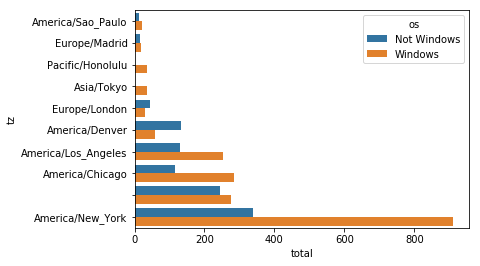

In [65]:
sns.barplot(x='total', y='tz', hue='os',  data=count_subset)

该图不容易看到较小组中的Windows用户的相对百分比，因此将组百分比归一化为1：

In [66]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group

results = count_subset.groupby('tz').apply(norm_total)

然后绘图：

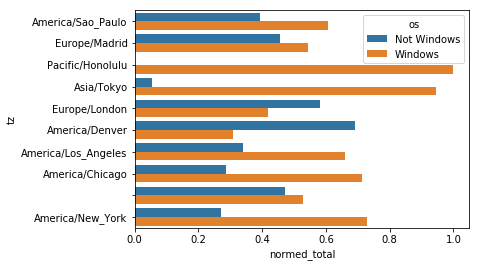

In [67]:
sns.barplot(x='normed_total', y='tz', hue='os',  data=results)

可以通过transform方法和groupby方法更有效地计算归一化之和：

In [68]:
g = count_subset.groupby('tz')
results2 = count_subset.total / g.total.transform('sum')

In [69]:
results2[:5]

0    0.393939
1    0.606061
2    0.457143
3    0.542857
4    0.000000
Name: total, dtype: float64

## 14.2　MovieLens 1M数据集
GroupLens实验室（http://www.grouplens.org/node/73 ）提供了一些从MovieLens用户那里收集的20世纪90年代末和21世纪初的电影评分数据的集合。这些数据提供了电影的评分、电影的元数据（流派和年份）以及观众数据（年龄、邮编、性别、职业）。这些数据通常会用于基于机器学习算法的推荐系统开发，虽然不会在本书中详细探讨机器学习技术，但会展示如何将这些数据集切片并切成需要的确切形式。

MovieLens 1M数据集包含6，000个用户对4，000部电影的100万个评分。数据分布在三个表格中：评分，用户信息和电影信息。从ZIP文件中提取数据后，我们可以使用pandas.read_table将每个表加载到一个pandas DataFrame对象中：

In [70]:
# 让展示内容少一点
pd.options.display.max_rows = 10

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_csv('datasets/movielens/users.dat', sep='::',
                    header=None, names=unames, engine='python')

In [71]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('datasets/movielens/ratings.dat', sep='::',
                      header=None, names=rnames, engine='python')

In [72]:
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_csv('datasets/movielens/movies.dat', sep='::',
                     header=None, names=mnames, engine='python')                    

可以通过使用Python的切片语法来查看每个DataFrame的前几行来验证一切是否成功：

In [73]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [74]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [75]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


请注意，年龄和职业被编码为整数，这些表示了数据集的README文件所描述的分组。跨越三个表格分析数据并不是一件简单的事情，例如，假设想按性别和年龄计算某个电影的平均评分。正如看到的，将所有表格合并到单个表中会更容易。使用pandas的合并功能，首先将ratings表与users表合并，然后将该结果与movies表数据合并。pandas根据重叠名称推断哪些列用作合并的（或连接）键位：

In [76]:
data = pd.merge(pd.merge(ratings, users), movies)
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [77]:
data.loc[0]

user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

为了获得按性别分级的每部电影的平均电影评分，可以使用`pivot_table`方法：

In [78]:
mean_ratings = data.pivot_table('rating', index='title',
                                columns='gender', aggfunc='mean')

mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [79]:
# 使用groupby改写，但是效率上有差距
data.groupby(by=['title', 'gender']).mean().unstack().rating.head()

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


上面的代码产生了另一个DataFrame，其中包含电影标题作为行标签（“索引”）和性别作为列标签的平均评分。首先过滤掉少于250（完全随意定的数字）个评分的电影；为此，接着按标题对数据进行分组，并使用`size()`为每个标题获取一个元素是各分组大小的Series：

In [80]:
ratings_by_title = data.groupby('title').size()

ratings_by_title.head()

title
$1,000,000 Duck (1971)            37
'Night Mother (1986)              70
'Til There Was You (1997)         52
'burbs, The (1989)               303
...And Justice for All (1979)    199
dtype: int64

In [81]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]

active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

评分多于250个的电影标题的索引之后可以用于从`mean_ratings`中选出所需的行：

In [82]:
# 在牵引上选取行
mean_ratings = mean_ratings.loc[active_titles]

mean_ratings.head()

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421


要看到女性观众的top电影，可以按F列降序排序：

In [83]:
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)

top_female_ratings.head()

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415


### 14.2.1　测量评价分歧
假设想找到男性和女性观众之间最具分歧性的电影。一种方法是添加一列到含有均值差的`mean_ratings`中，然后按以下方式排序：

In [84]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

按照'diff'排序产生评分差异最大的电影，以便可以看到哪些是女性首选的：

In [85]:
sorted_by_diff = mean_ratings.sort_values(by='diff')

sorted_by_diff.head()

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777


转换行的顺序，并切片出top 10的行，就可以获得男性更喜欢但女性评分不高的电影：

In [86]:
# 对行倒序，取前10行
sorted_by_diff[::-1][:10]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


假设想要的是不依赖于性别标识而在观众中引起最大异议的电影。异议可以通过评分的方差或标准差来衡量。

In [87]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()

# Filter down to active_titles
rating_std_by_title = rating_std_by_title.loc[active_titles]

# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

电影流派是以管道分隔（|）字符串的形式给出的。如果想按流派做一些分析，需要做更多的工作来将流派信息转化为更有用的形式。

## 14.3　美国1880～2010年的婴儿名字
美国社会保障局（SSA）提供了从1880年至现在的婴儿姓名频率的数据。Hadley Wickham是一些流行R包的作者，他经常利用这个数据集来说明R中的数据操作。

需要做一些数据规整来加载这个数据集，但一旦这样做，将得到一个看起来如下的DataFrame：

In [4]: names.head(10)
Out[4]:
        name sex  births  year
0       Mary   F    7065  1880
1       Anna   F    2604  1880
2       Emma   F    2003  1880
3  Elizabeth   F    1939  1880
4     Minnie   F    1746  1880
5   Margaret   F    1578  1880
6        Ida   F    1472  1880
7      Alice   F    1414  1880
8     Bertha   F    1320  1880
9      Sarah   F    1288  1880

要对数据集做很多事情：

* 根据给定的名字（可以是你自己的，或另一个名字）对婴儿名字随时间的比例进行可视化

* 确定一个名字的相对排位

* 确定每年最受欢迎的名字，或者流行程度最高或最低的名字

* 分析名字趋势：元音、辅音、长度、整体多样性、拼写变化、第一个和最后一个字母

* 分析额外的趋势来源：圣经中的名字，名人，人口变化

通过介绍的工具，许多这些分析都可以实现，所以会引导了解其中的一部分。

截至撰写本书时，美国社会保障局每年提供一份数据文件，其中包含每个性别/姓名组合的出生总数。这些文件的原始档案可以从http://www.ssa.gov/oact/babynames/limits.html 获得。

如果阅读本书时，上面的网页被移动了，你可以再次通过互联网搜索找到该页面。下载“国家数据”文件names.zip并解压缩，你将拥有一个包含一系列文件（如yob1981.txt）的目录。使用Unix head命令查看其中一个文件的前10行（在Windows上，可以使用more命令或在文本编辑器中打开它）：

In [88]:
!head -n 10 datasets/babynames/yob1981.txt

由于它已经以逗号分隔的形式出现，因此可以使用`pandas.read_csv`将其加载到DataFrame中：

In [89]:
import pandas as pd

names1981 = pd.read_csv('datasets/babynames/yob1981.txt',
                        names=['name', 'sex', 'births'])

names1981.head()

,name,sex,births
0,Jennifer,F,57029
1,Jessica,F,42519
2,Amanda,F,34366
3,Sarah,F,28163
4,Melissa,F,28000


这些文件只包含每年至少有五次出现的名字，为简单起见，按性别列出的出生总和作为当年的出生总数：

In [90]:
names1981.groupby(by='sex').births.sum()

sex
F    1666833
M    1789568
Name: births, dtype: int64

由于数据集按年分为多个文件，首先要做的事情之一是将所有数据集中到一个DataFrame中，然后再添加一个年份字段。可以使用`pandas.concat`来做到这一点：

In [91]:
years = range(1981, 1986)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = 'datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)

    frame['year'] = year
    pieces.append(frame)

# 将所有内容粘接进一个DataFrame
names = pd.concat(pieces, ignore_index=True)

> 首先，`concat`默认情况下将DataFrame对象以逐行方式黏合在一起。其次，必须传递`ignore_index=True`，因为不想保留从`read_csv`返回的原始行号。

现在有了一个非常大的包含所有名字数据的DataFrame：

In [92]:
names

,name,sex,births,year
0,Jennifer,F,57029,1981
1,Jessica,F,42519,1981
2,Amanda,F,34366,1981
3,Sarah,F,28163,1981
4,Melissa,F,28000,1981
...,...,...,...,...
98059,Zephyr,M,5,1985
98060,Zeshan,M,5,1985
98061,Zeus,M,5,1985
98062,Zia,M,5,1985


掌握这些数据后，可以使用`groupby`或`pivot_table`开始聚合年份和性别的数据：

In [93]:
total_births = names.pivot_table('births', index='year',
                                 columns='sex', aggfunc=sum)

total_births.tail()

sex,F,M
year,,
1981,1666833,1789568
1982,1692036,1812642
1983,1669486,1790670
1984,1682396,1802735
1985,1719450,1846162


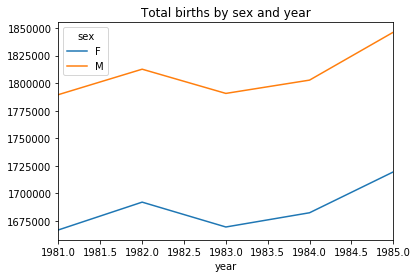

In [94]:
total_births.plot(title='Total births by sex and year')

接下来，插入一个prop列，给出每个婴儿名字相对于出生总数的比例。prop值为0.02表示每100个婴儿中有2个起了某个名字。因此，按年份和性别对数据进行分组，然后将新列添加到每个组：

In [95]:
def add_prop(group):
    group['prop'] = group.births / group.births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)

生成的完整数据集现在具有以下列：

In [96]:
names.head()

,name,sex,births,year,prop
0,Jennifer,F,57029,1981,0.034214
1,Jessica,F,42519,1981,0.025509
2,Amanda,F,34366,1981,0.020618
3,Sarah,F,28163,1981,0.016896
4,Melissa,F,28000,1981,0.016798


在执行此类组操作时，进行完整性检查通常很有价值，例如验证所有组中的prop列总计为1：

In [97]:
names.groupby(['year', 'sex']).prop.sum()

year  sex
1981  F      1.0
      M      1.0
1982  F      1.0
      M      1.0
1983  F      1.0
      M      1.0
1984  F      1.0
      M      1.0
1985  F      1.0
      M      1.0
Name: prop, dtype: float64

现在完成了，提取一部分数据以便于进一步分析：每个性别/年份组合的前1,000名。这是另一个小组操作：

In [98]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
# 删除组索引，不需要它
top1000.reset_index(inplace=True, drop=True)

In [99]:
names

,name,sex,births,year,prop
0,Jennifer,F,57029,1981,0.034214
1,Jessica,F,42519,1981,0.025509
2,Amanda,F,34366,1981,0.020618
3,Sarah,F,28163,1981,0.016896
4,Melissa,F,28000,1981,0.016798
...,...,...,...,...,...
98059,Zephyr,M,5,1985,0.000003
98060,Zeshan,M,5,1985,0.000003
98061,Zeus,M,5,1985,0.000003
98062,Zia,M,5,1985,0.000003


如果喜欢其他方式，可以试试以下代码：

In [100]:
pieces = []
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
top1000 = pd.concat(pieces, ignore_index=True)

结果数据集现在比较小：

In [101]:
top1000

,name,sex,births,year,prop
0,Jennifer,F,57029,1981,0.034214
1,Jessica,F,42519,1981,0.025509
2,Amanda,F,34366,1981,0.020618
3,Sarah,F,28163,1981,0.016896
4,Melissa,F,28000,1981,0.016798
...,...,...,...,...,...
9995,Deric,M,84,1985,0.000045
9996,Emmett,M,84,1985,0.000045
9997,Deshaun,M,83,1985,0.000045
9998,Jabari,M,83,1985,0.000045


将在后续的数据调查中使用这个top1000数据集。

### 14.3.1　分析名字趋势
利用完整的数据集和手上的top1000数据集，可以开始分析各种感兴趣的命名趋势。首先，分成男孩和女孩两部分是很容易实现的：

In [102]:
boys = top1000[top1000.sex == 'M']

girls = top1000[top1000.sex == 'F']

简单的时间序列，比如每年的John或Marry的数量，都可以绘制出来，但是需要一些处理才能更有用。按年份和名字形成出生总数的数据透视表：

In [103]:
total_births = top1000.pivot_table('births', index='year',
                                   columns='name',
                                   aggfunc=sum)

现在，可以使用DataFrame的plot方法绘制少数名称的透视表：

In [104]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1981 to 1985
Columns: 2174 entries, Aaron to Zoe
dtypes: float64(2174)
memory usage: 85.0 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca92e2ed30>,
      dtype=object)

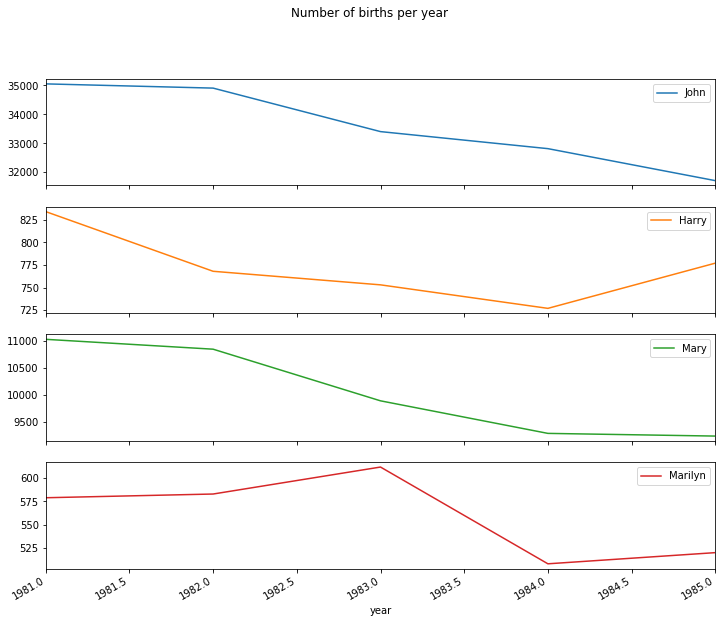

In [105]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title="Number of births per year")

看着上图，可能会得出结论，这些名字已经不适合美国人了。但是故事实际上比这更复杂，下一节将会探讨这个故事。

#### 14.3.1.1　计量命名多样性的增加

对上一节中趋势下降的一个解释是，越来越多的父母为他们的孩子选择常用名字。这个假设可以在数据中进行探索和确认。其中一个衡量指标是Top 1，000最受欢迎的名字所涵盖婴儿的出生比例，按照年份和性别进行聚合和绘图：

In [106]:
table = top1000.pivot_table('prop', index='year',
                            columns='sex', aggfunc=sum)

table.head()

sex,F,M
year,,
1981,0.867232,0.944762
1982,0.868208,0.944435
1983,0.871602,0.945170
1984,0.870201,0.944705
1985,0.866046,0.942412


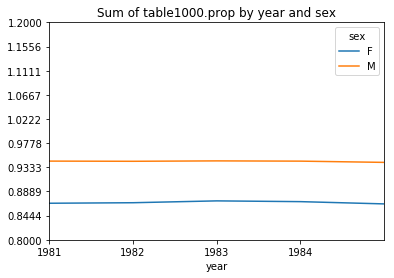

In [107]:
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0.8, 1.2, 10), xticks=range(1981, 1985, 1))

可以看到，事实上似乎有越来越多的名字多样性（Top 1，000名字的总比例的降低）。另一个有趣的指标是不同名字的数量，按最高到最低的受欢迎程度在出生人数最高的50%的名字中排序。这个数字计算起来有点棘手。让考虑一下1985年的男孩名字：

In [108]:
df = boys[boys.year == 1985]

df.head()

,name,sex,births,year,prop
9000,Michael,M,64862,1985,0.035133
9001,Christopher,M,59566,1985,0.032265
9002,Matthew,M,47025,1985,0.025472
9003,Joshua,M,42176,1985,0.022845
9004,Daniel,M,38513,1985,0.020861


按降序排列prop后，想知道有多少名字是最受欢迎的那50％。可以写一个for循环来实现这一点，但矢量化的NumPy方式更聪明一些。获取prop的累积总和`cumsum`，然后调用`searchsorted`方法返回累积总和中的位置，在该处需要插入0.5以保持排序顺序：

In [109]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()

prop_cumsum[:10]

9000    0.035133
9001    0.067398
9002    0.092870
9003    0.115715
9004    0.136576
9005    0.157424
9006    0.176827
9007    0.194195
9008    0.211246
9009    0.227601
Name: prop, dtype: float64

In [110]:
prop_cumsum.values.searchsorted(0.5)

35

由于数组是零索引的，所以给这个结果加1会得到36的结果。相比之下，在1981年这个数字是35：

In [111]:
df = boys[boys.year == 1981]

in1981 = df.sort_values(by='prop', ascending=False).prop.cumsum()

in1981.values.searchsorted(0.5) + 1

35

现在可以将此操作应用于每个年/性别分组，通过这些字段进行`groupby`，并将返回值是每个分组计数值的函数`apply`到每个分组上：

In [112]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

产生的DataFrame diversity现在有两个时间序列，每个时间序列对应一种性别，并按照年份索引。diversity像之前一样可以在IPython中被检查并绘制：

In [113]:
diversity.head()

sex,F,M
year,,
1981,78,35
1982,75,35
1983,71,34
1984,71,35
1985,72,36


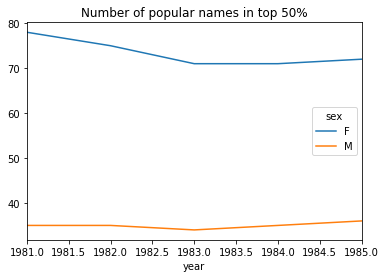

In [114]:
diversity.plot(title="Number of popular names in top 50%")

可以看到，女孩的名字一直比男孩的名字更加多样化，而且随着时间的推移它们变得越来越多。可以进一步分析究竟是什么促成了多样性，比如增加了其他拼写方法。

#### 14.3.1.2　“最后一个字母”革命

2007年，婴儿名字研究员Laura Wattenberg在她的网站（http://www.babynamewizard.com ）上指出，男孩名字最后一个字母的分布在过去的一百年里发生了重大变化。为了看到这一点，我们首先按照年份、性别和最后一个字母汇总完整数据集中的所有出生情况：

In [115]:
# 从name列提取最后一个字母
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters,
                          columns=['sex', 'year'], aggfunc=sum)

然后，选出历史上三个有代表性的年份并列出前几行：

In [116]:
subtable = table.reindex(columns=[1981, 1983, 1985], level='year')

subtable.head()

sex                 F                             M                    
year             1981      1983      1985      1981      1983      1985
last_letter                                                            
a            628684.0  606713.0  624123.0   45465.0   42915.0   49105.0
b                97.0     115.0     127.0   11428.0   13394.0   14998.0
c               434.0     405.0     443.0   28039.0   27625.0   28552.0
d              1917.0    1982.0    1950.0  124490.0  115659.0  110894.0
e            312604.0  308686.0  319732.0  112976.0  114382.0  122448.0

接下来，按照出生总数对表格进行归一化处理，计算一个新表格，其中包含每个性别的每个结束字母占总出生数的比例：

In [117]:
subtable.sum()

sex  year
F    1981    1666833.0
     1983    1669486.0
     1985    1719450.0
M    1981    1789568.0
     1983    1790670.0
     1985    1846162.0
dtype: float64

In [118]:
letter_prop = subtable / subtable.sum()

letter_prop

sex                 F                             M                    
year             1981      1983      1985      1981      1983      1985
last_letter                                                            
a            0.377173  0.363413  0.362978  0.025406  0.023966  0.026598
b            0.000058  0.000069  0.000074  0.006386  0.007480  0.008124
c            0.000260  0.000243  0.000258  0.015668  0.015427  0.015466
d            0.001150  0.001187  0.001134  0.069564  0.064590  0.060067
e            0.187544  0.184899  0.185950  0.063130  0.063877  0.066326
...               ...       ...       ...       ...       ...       ...
v            0.000007  0.000005  0.000005  0.000162  0.000133  0.000168
w            0.000266  0.000387  0.000400  0.037096  0.044311  0.044246
x            0.000082  0.000089  0.000131  0.001852  0.001967  0.003006
y            0.141196  0.155304  0.164144  0.109612  0.103872  0.106783
z            0.000574  0.000532  0.000511  0.000563  0.000673  0.000752

[26 rows x 6 columns]

现在根据掌握的字母比例，可以绘制出按年划分的每个性别的条形图：

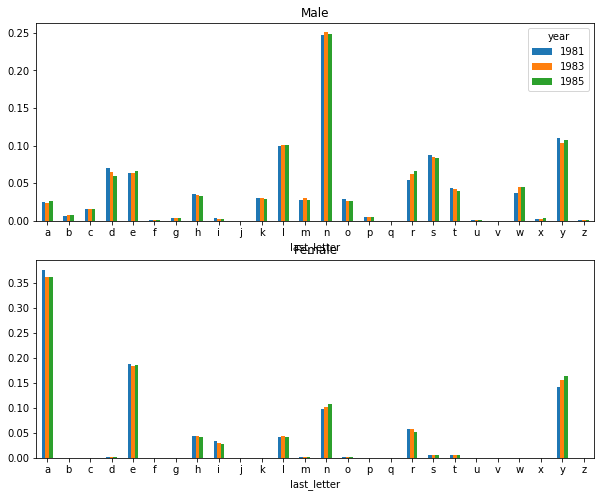

In [119]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female',
                      legend=False)

自20世纪60年代以来，以n结尾的男孩名字经历了显著的增长。回到之前创建的完整表格，再次按年份和性别进行标准化，并为男孩名字选择一个字母子集，最后转换为使每列成为一个时间序列：

In [120]:
letter_prop = table / table.sum()

dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T

dny_ts.head()

last_letter,d,n,y
year,,,
1981,0.069564,0.247668,0.109612
1982,0.067343,0.247982,0.107810
1983,0.064590,0.250570,0.103872
1984,0.062247,0.249121,0.104434
1985,0.060067,0.249074,0.106783


根据掌握的时间序列DataFrame，可以使用`plot`方法绘制字母随时间变化的趋势：

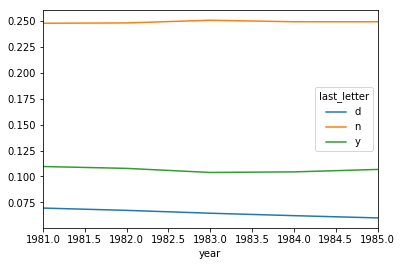

In [121]:
dny_ts.plot()

### 14.3.1.3　男孩名字变成女孩名字（以及反向）

另一个有趣的趋势是看到样本中较早在男性中流行的男孩名字，但现在已经“改变了性别”。一个例子是Lesley或Leslie的名字。回到top1000的DataFrame，计算数据集中以“lesl”开头的名字列表：

In [122]:
all_names = pd.Series(top1000.name.unique())

lesley_like = all_names[all_names.str.lower().str.contains('lesl')]

lesley_like

55     Leslie
281    Lesley
dtype: object

从DataFrame那里，可以过滤掉那些名字，并对按名字分组的出生数进行累加来看相关频率：

In [123]:
filtered = top1000[top1000.name.isin(lesley_like)]

filtered.groupby('name').births.sum()

name
Lesley     3603
Leslie    23611
Name: births, dtype: int64

之后，让按性别和年份进行聚合，并在年内进行标准化：

In [124]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')

table = table.div(table.sum(1), axis=0)

table.tail()

sex,F,M
year,,
1981,0.920584,0.079416
1982,0.931134,0.068866
1983,0.923177,0.076823
1984,0.923318,0.076682
1985,0.926428,0.073572


最后可以绘制出按性别随时间推移的分解图：

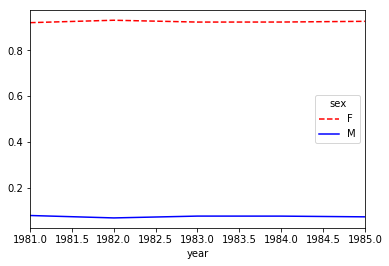

In [125]:
table.plot(style={'M': 'b-', 'F': 'r--'})

## 14.4　美国农业部食品数据库
美国农业部（US Department of Agriculture，USDA）提供了食物营养信息数据库。程序员Ashley Williams以JSON格式提供了这个数据库的一个版本。记录如下所示：
```json
{
  "id": 21441,
  "description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY,
Wing, meat and skin with breading",
  "tags": ["KFC"],
  "manufacturer": "Kentucky Fried Chicken",
  "group": "Fast Foods",
  "portions": [
    {
      "amount": 1,
      "unit": "wing, with skin",
      "grams": 68.0
    },
    ...

  ],
  "nutrients": [
    {
      "value": 20.8,
      "units": "g",
      "description": "Protein",
      "group": "Composition"
    },

    ...
  ]
}
```

每种食物都有一些识别属性以及两份营养元素和营养比例的列表。这种形式的数据不适合分析，所以需要做一些工作来将数据转换成更好的形式。

从链接下载并提取数据后，可以使用选择的任何JSON库将其加载到Python中。将使用内置的Python `json`模块：

In [126]:
import json

db = json.load(open('datasets/usda_food/database.json'))

len(db)

6636

db中的每个条目都是一个包含单个食物所有数据的词典。'nutrients'字段是一个字典的列表，每个营养元素对应一个字典：

In [127]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [128]:
db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [129]:
nutrients = pd.DataFrame(db[0]['nutrients'])

nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


将字典的列表转换为DataFrame时，可以指定一个需要提取的字段列表。将提取食物名称、分类、ID和制造商：

In [130]:
info_keys = ['description', 'group', 'id', 'manufacturer']

info = pd.DataFrame(db, columns=info_keys)

info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [131]:
info.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


可以通过`value_counts`查看食物组的分布情况：

In [132]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Fast Foods                           365
Legumes and Legume Products          365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Name: group, dtype: int64

In [133]:
# 有缺失值时会不准确
info.groupby(by='group').count().sort_values(by='id', ascending=False).head(10)

,description,id,manufacturer
group,,,
Vegetables and Vegetable Products,812,812,744
Beef Products,618,618,487
Baked Products,496,496,329
Breakfast Cereals,403,403,335
Fast Foods,365,365,327
Legumes and Legume Products,365,365,307
"Lamb, Veal, and Game Products",345,345,343
Sweets,341,341,251
Pork Products,328,328,230


In [134]:
# 另一种改写方式
info.group.value_counts().head(10)

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Fast Foods                           365
Legumes and Legume Products          365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Name: group, dtype: int64

现在，对所有营养元素数据进行一些分析，将每种食物的营养元素组装成一张大表是最容易的。为此，需要采取几个步骤。首先，将食物营养元素的每个列表转换为DataFrame，为食物添加一列id，然后将DataFrame附加到列表中。然后，这些DataFrame可以通过`concat`连接在一起：

In [135]:
list_nutrients = []
for db_cnt in range(len(db)):
    for nutrient_cnt in range(len(db[db_cnt]['nutrients'])):
        nutrient = db[db_cnt]['nutrients'][nutrient_cnt]
        nutrient['id'] = db[db_cnt]['id']
        list_nutrients.append(nutrient)

df_nutrients = pd.DataFrame(list_nutrients)

In [136]:
df_nutrients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389355 entries, 0 to 389354
Data columns (total 5 columns):
description    389355 non-null object
group          389355 non-null object
id             389355 non-null int64
units          389355 non-null object
value          389355 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.9+ MB


如果一切顺利，df_nutrients将如下：

In [137]:
df_nutrients

,description,group,id,units,value
0,Protein,Composition,1008,g,25.180
1,Total lipid (fat),Composition,1008,g,29.200
2,"Carbohydrate, by difference",Composition,1008,g,3.060
3,Ash,Other,1008,g,3.280
4,Energy,Energy,1008,kcal,376.000
...,...,...,...,...,...
389350,"Vitamin B-12, added",Vitamins,43546,mcg,0.000
389351,Cholesterol,Other,43546,mg,0.000
389352,"Fatty acids, total saturated",Other,43546,g,0.072
389353,"Fatty acids, total monounsaturated",Other,43546,g,0.028


注意到这个DataFrame中有重复的东西，所以删除重复值更好：

In [138]:
df_nutrients.duplicated().sum()  # 重复的数量

14179

In [139]:
df_nutrients = df_nutrients.drop_duplicates()

因为'group'和'description'都是在DataFrame对象中的，可以明确地重命名：

In [140]:
col_mapping = {'description' : 'food',
               'group'       : 'fgroup'}

info = info.rename(columns=col_mapping, copy=False)

info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
food            6636 non-null object
fgroup          6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [141]:
col_mapping = {'description' : 'nutrient',
               'group' : 'nutgroup'}

df_nutrients = df_nutrients.rename(columns=col_mapping, copy=False)

df_nutrients

,nutrient,nutgroup,id,units,value
0,Protein,Composition,1008,g,25.180
1,Total lipid (fat),Composition,1008,g,29.200
2,"Carbohydrate, by difference",Composition,1008,g,3.060
3,Ash,Other,1008,g,3.280
4,Energy,Energy,1008,kcal,376.000
...,...,...,...,...,...
389350,"Vitamin B-12, added",Vitamins,43546,mcg,0.000
389351,Cholesterol,Other,43546,mg,0.000
389352,"Fatty acids, total saturated",Other,43546,g,0.072
389353,"Fatty acids, total monounsaturated",Other,43546,g,0.028


完成所有这些工作后，准备将info与nutrients合并：

In [142]:
ndata = pd.merge(df_nutrients, info, on='id', how='outer')
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
nutrient        375176 non-null object
nutgroup        375176 non-null object
id              375176 non-null int64
units           375176 non-null object
value           375176 non-null float64
food            375176 non-null object
fgroup          375176 non-null object
manufacturer    293054 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [143]:
ndata.iloc[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
id                                                6158
units                                                g
value                                             0.04
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

现在可以根据食物组和营养类型制作一个中位数图（见图14-11）：

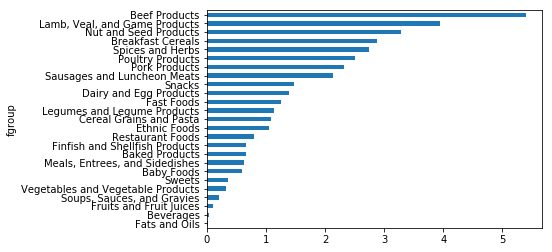

In [144]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh')

可以发现哪种食物在每个营养元素下有最密集的营养：

In [145]:
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

get_maximum = lambda x: x.loc[x.value.idxmax()]
get_minimum = lambda x: x.loc[x.value.idxmin()]

max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

# 使food小一点
max_foods.food = max_foods.food.str[:50]

这里展示'Amino Acids'（氨基酸）营养组：

In [146]:
max_foods.loc['Amino Acids']

,value,food
nutrient,,
Alanine,8.009,"Gelatins, dry powder, unsweetened"
Arginine,7.436,"Seeds, sesame flour, low-fat"
Aspartic acid,10.203,Soy protein isolate
Cystine,1.307,"Seeds, cottonseed flour, low fat (glandless)"
Glutamic acid,17.452,Soy protein isolate
...,...,...
Serine,4.600,"Soy protein isolate, PROTEIN TECHNOLOGIES INTE..."
Threonine,3.300,"Soy protein isolate, PROTEIN TECHNOLOGIES INTE..."
Tryptophan,1.600,"Sea lion, Steller, meat with fat (Alaska Native)"


## 14.5　2012年联邦选举委员会数据库
美国联邦选举委员会公布了有关政治运动贡献的数据。这些数据包括捐赠者姓名、职业和雇主、地址和缴费金额。一个有趣的数据来自2012年美国总统大选。在2012年6月下载的一个数据集版本是一个150兆字节的CSV文件P00000001-ALL.csv，该文件可以使用`pandas.read_csv`加载：

In [147]:
fec = pd.read_csv('datasets/fec/P00000001-ALL.csv')

fec.info()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


DataFrame中的一条样本记录如下：

In [148]:
fec.iloc[123456].index

Index(['cmte_id', 'cand_id', 'cand_nm', 'contbr_nm', 'contbr_city',
       'contbr_st', 'contbr_zip', 'contbr_employer', 'contbr_occupation',
       'contb_receipt_amt', 'contb_receipt_dt', 'receipt_desc', 'memo_cd',
       'memo_text', 'form_tp', 'file_num'],
      dtype='object')

可能会想到一些方法来切片和切块这些数据，以提取有关捐助者和竞选捐助模式的统计信息。

可以看到数据中没有政党背景，加入这些数据很有用。可以使用`unique`获得所有不同的政治候选人名单：

In [149]:
unique_cands = fec.cand_nm.unique()

print(unique_cands)
print("-"*50)
print(unique_cands[2])

['Bachmann, Michelle' 'Romney, Mitt' 'Obama, Barack'
 "Roemer, Charles E. 'Buddy' III" 'Pawlenty, Timothy' 'Johnson, Gary Earl'
 'Paul, Ron' 'Santorum, Rick' 'Cain, Herman' 'Gingrich, Newt'
 'McCotter, Thaddeus G' 'Huntsman, Jon' 'Perry, Rick']
--------------------------------------------------
Obama, Barack


表示政党背景的方式之一是使用相应的字典：

In [150]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

现在，在Series对象上使用`map`方法和上述的映射关系，可以从候选人姓名中计算出政党的数组：

In [151]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [152]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [153]:
# 将它作为一列加入
fec['party'] = fec.cand_nm.map(parties)

fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

有一些数据准备的要点。首先，这些数据既包括捐款也包括退款（即负贡献金额）：

In [154]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

为了简化分析，将分析范围限制在正向贡献中：

In [155]:
fec = fec[fec.contb_receipt_amt > 0]

由于Barack Obama和Mitt Romney是主要的两位候选人，还将准备一个仅对他们的竞选有贡献的子集：

In [156]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### 14.5.1　按职业和雇主的捐献统计
根据职业分析捐献是一个常见的统计分析。例如，律师（法律代理人）倾向于捐更多的钱给民主党，而商务人士则倾向于捐更多的钱给共和党。可以自己看数据。首先，获得按职业的捐献总数是很简单的：

In [157]:
fec.contbr_occupation.value_counts().head()

RETIRED                  233990
INFORMATION REQUESTED     35107
ATTORNEY                  34286
HOMEMAKER                 29931
PHYSICIAN                 23432
Name: contbr_occupation, dtype: int64

通过查看职业，会注意到很多捐款人都有相同的基础工作类型，或者说对于同一件事情有多个变量。下面的代码段表明如何通过将一种工作匹配到另一种来清理工作种类；

> 请注意，使用`dict.get`存在一种"陷阱"，允许没有映射的职业"通过"：

In [158]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# 如果没有映射，则返回x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

对雇主字段做同样的事：

In [159]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}
# 如果没有映射，则返回x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

现在，可以使用`pivot_table`按党派和职业聚合数据，然后过滤出至少捐赠200万美元的子集：

In [160]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')
by_occupation.head()

party,Democrat,Republican
contbr_occupation,,
MIXED-MEDIA ARTIST / STORYTELLER,100.0,NaN
AREA VICE PRESIDENT,250.0,NaN
RESEARCH ASSOCIATE,100.0,NaN
TEACHER,500.0,NaN
THERAPIST,3900.0,NaN


In [161]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]

over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
...,...,...
PRESIDENT,1878509.95,4.720924e+06
PROFESSOR,2165071.08,2.967027e+05
REAL ESTATE,528902.09,1.625902e+06


以条形图的方式进行数据可视化更为简单：

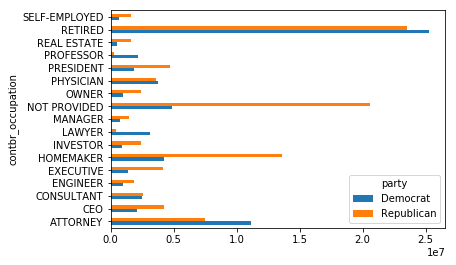

In [162]:
over_2mm.plot(kind='barh')

可能对捐赠给Obama和Romney的顶级捐赠者的职业或顶级公司感兴趣。要实现这一点，可以按候选人名称进行分组，并使用前面的`top`方法的变体：

In [163]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)

之后按职业和雇主进行聚合：

In [164]:
grouped = fec_mrbo.groupby('cand_nm')

grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation    
Obama, Barack  RETIRED                  25305116.38
               ATTORNEY                 11141982.97
               INFORMATION REQUESTED     4866973.96
               HOMEMAKER                 4248875.80
               PHYSICIAN                 3735124.94
                                           ...     
Romney, Mitt   HOMEMAKER                 8147446.22
               ATTORNEY                  5364718.82
               PRESIDENT                 2491244.89
               EXECUTIVE                 2300947.03
               C.E.O.                    1968386.11
Name: contb_receipt_amt, Length: 14, dtype: float64

In [165]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer      
Obama, Barack  RETIRED                  22694358.85
               SELF-EMPLOYED            17080985.96
               NOT EMPLOYED              8586308.70
               INFORMATION REQUESTED     5053480.37
               HOMEMAKER                 2605408.54
                                           ...     
Romney, Mitt   CREDIT SUISSE              281150.00
               MORGAN STANLEY             267266.00
               GOLDMAN SACH & CO.         238250.00
               BARCLAYS CAPITAL           162750.00
               H.I.G. CAPITAL             139500.00
Name: contb_receipt_amt, Length: 20, dtype: float64

### 14.5.2　捐赠金额分桶
分析这些数据的一个有用的方法是使用`cut`函数将贡献者的数量按贡献大小离散化分桶：

In [166]:
bins = np.array([0, 1, 10, 100, 1000, 10000,
                 100000, 1000000, 10000000])

labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)

labels.head()

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (8, interval[int64]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

然后，可以将Obama和Romney的数据按名称和分类标签进行分组，以获得捐赠规模的直方图：

In [167]:
grouped = fec_mrbo.groupby(['cand_nm', labels])

grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


这些数据表明，Obama获得的捐款数量比Romney大得多。还可以对捐款数额进行求和并在桶内进行归一化，以便对按候选人划分的捐款总额百分比进行可视化：

In [168]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)

normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)

normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


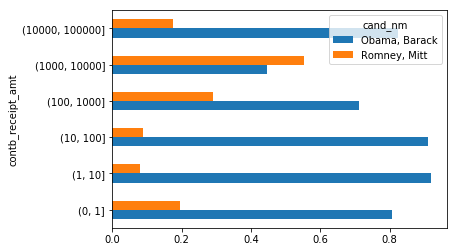

In [169]:
normed_sums[:-2].plot(kind='barh')

排除了两个最大的箱体，因为这些箱体不是由个人捐赠的。

这种分析可以通过多种方式进行改进和提高。例如，可以通过捐助者姓名和邮政编码聚合捐款，以便为那些进行很多次小额捐赠的人进行调整，他们并不会进行大型捐赠。

### 14.5.3　按州进行捐赠统计
将数据按照候选人和州进行聚合是一项常规分析：

In [170]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])

totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)

totals = totals[totals.sum(1) > 100000]

totals.head()

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60


如果将每一行除以捐款总额，就可以得到每个候选人按州的捐赠总额的相对百分比：

In [171]:
percent = totals.div(totals.sum(1), axis=0)

percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
